# P12-14 Mouse brains
## Analysis of gene expression, clonality, and location for microglia in mice.

Barcodes were injected into mouse embryos at E9.5.  This notebook carries out analysis at time points P12-14.  The cells come from two mice and three parts of the brain, coded as follows.



Most of the cells are microglia, and the data contains the expression of a few thousand genes for each cell.  Moreover, barcodes allow us to identify cells belonging to the same clone.  We are interested in whether microglia from one clone are more similar to each other or microglia from one brain area. 

The following are the notebook contents.  Skip step 1, if the data-pickles are already present.

1.  [Preprocessing](#Prep)
2.  [Description and exploration](#Desc)
3.  [Machine learning via linear SVM](#SVM)
4.  [Differential gene expression](#DGE)

<a id='Prep'></a>
## 1. Preprocessing

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

### 1.1 Loading the data

We load the gene expression data and some metadata.  The gene expression data is stored in a large expression matrix, as a CSV file.  The metadata is stored in a separate file.  We load the metadata below, ignoring cells with CloneID zero.  

In [2]:
meta_df = pd.read_csv('P12-14_datasets/10x65-67_metadata.csv', sep=',',
                      index_col=0, header=0, low_memory=False)
meta_df = meta_df[ meta_df['CloneID'] != 0] # Only take cells with known clonotype.
meta_df.CloneID = meta_df.CloneID.apply(str) # Convert clone-labels to strings.

clones = meta_df['CloneID'].unique()
celltypes = meta_df['Celltype'].unique()
areas = meta_df['Area'].unique()
cells = list(meta_df.index)

print('{} single cells found, from {} to {}'.format(len(cells), cells[0], cells[-1]))
print('{} clones found: {}'.format(len(clones), ', '.join(clones)))
print('{} cell types found: {}'.format(len(celltypes), ', '.join(celltypes)))
print('{} areas found: {}'.format(len(areas), ', '.join(areas)))
print('The first five rows of the dataframe are below')
display(meta_df.head())

65 single cells found, from AGAGCAGTCACTAGCA_1 to TTTGTTGTCCGTGACG_3
4 clones found: 423, 72, 358, 2700
8 cell types found: Microglia, AstrocytesGM, OPCs, GranuleNeuroblasts, COPs, DGRGLs, NIPCs, exNeurons
3 areas found: cx, hc, str
The first five rows of the dataframe are below


,CloneID,Celltype,Area,Clonesize
AGAGCAGTCACTAGCA_1,423,Microglia,cx,19.0
CGGCAGTGTCACCGAC_1,423,Microglia,cx,19.0
CGGGTCATCTGAGAGG_1,423,Microglia,cx,19.0
GTGACGCCAGAGGTAC_1,423,Microglia,cx,19.0
GTTGAACGTCGTTGGC_1,423,Microglia,cx,19.0


In [3]:
cells = meta_df.index[meta_df['Celltype'] == 'Microglia'].tolist() # Restrict to Microglia
print('{} microglia found'.format(len(cells)))

54 microglia found


The expression matrix is pretty huge, containing over 20000 cells.  We will load the whole thing, then extract the data for the (roughly 1000) cells of interest.

In [4]:
EM_filepath = 'P12-14_datasets/10x65-67_expression_matrix.csv' # Change as needed.

EM_df = pd.read_csv(EM_filepath, sep=',',index_col=0, header=0, low_memory=False)

In [5]:
EM_df = EM_df[cells] # We only care about the cells with known clonotype.
EM_df = EM_df.transpose() # Cells as rows, genes as columns now.
EM_df.head()

,Nrgn,Mal,Slc17a7,Tm4sf1,Ube2c,C1qa,Snca,Tmem2,Trf,Cplx3,...,Meox1,Gpr6,Dgkg,Ppp1r17,Tle4,Cyr61,Mt3,Ptprc,4933407L21Rik,Kcne1l
AGAGCAGTCACTAGCA_1,-0.556732,-0.094399,-0.617055,-0.110943,1.681850,4.351139,0.192789,-0.240803,2.680962,-0.167160,...,-0.209123,-0.107481,-0.310117,-0.250700,0.311373,-0.383834,-1.187159,4.104215,-0.187963,-0.594450
CGGCAGTGTCACCGAC_1,-0.062718,-0.195220,-0.752786,-0.110943,-0.230072,5.489158,-1.353702,-0.439144,-0.043694,8.828426,...,-0.209123,-0.036259,-0.320113,-0.276752,-1.345829,-0.396144,-1.201260,5.814177,-0.187963,-0.594463
CGGGTCATCTGAGAGG_1,-1.339879,-0.156833,0.743604,-0.110943,-0.230072,4.417944,0.504680,-0.447672,1.573834,-0.308944,...,-0.209123,-0.146361,-0.320658,-0.300210,0.440969,-0.391402,-1.190845,4.028540,-0.187963,-0.594463
GTGACGCCAGAGGTAC_1,0.479315,-0.136124,-0.672518,-0.110943,-0.230072,4.124801,0.077792,-0.471681,2.604860,-0.252930,...,-0.209123,-0.036259,-0.322367,-0.265033,0.785310,-0.397373,-1.189367,4.826587,-0.187963,-0.594463
GTTGAACGTCGTTGGC_1,0.348340,-0.229490,-0.632822,-0.110943,-0.230290,4.788602,-1.260496,-0.413927,0.316178,-0.151716,...,-0.209123,-0.036259,-0.317162,-0.268369,-1.307388,-0.399590,-1.166723,6.274468,-0.187963,-0.594463


In [6]:
EM_df.to_pickle('10x65-67_EM_full.pkl') # Save file as a pickle.
meta_df.to_pickle('10x65-67_meta.pkl') # Pickle the metadata too.

### 1.2.  Munging data

Now we preprocess the data for downstream use.

In [7]:
EM_raw = pd.read_pickle('10x65-67_EM_full.pkl') # Load expression matrix from a pickle.
meta_df = pd.read_pickle('10x65-67_meta.pkl') # Load metadata from a pickle.

In [8]:
genes = list(EM_raw.columns)  # The names of the genes. 
cells = list(EM_raw.index) # The names of the cells.
clones = meta_df['CloneID'].unique()
areas = meta_df['Area'].unique()

We filter genes, to only include genes that are expressed above a threshold, in a certain percentage of cells.  We also provide the option to exclude genes from a supplied list, if necessary.

In [9]:
def get_relevant(gf, eg = [], prevalence=0.05, threshold = 0):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    0 or above.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [10]:
genes_relevant = get_relevant(EM_raw)

In [11]:
print("{} Microglia cells are included, from {} to {}.".format(len(cells), cells[0], cells[-1]))
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), 
                                                                genes_relevant[0], genes_relevant[-1]))

54 Microglia cells are included, from AGAGCAGTCACTAGCA_1 to TTTGTTGTCCGTGACG_3.
2000 genes are measured, from Nrgn to Kcne1l.
708 genes are considered relevant, from Nrgn to Ptprc.


Next we remove poor quality libraries -- by removing cells which express too few genes.  We also remove cells that may be dividing, and thus express too many genes.  To visualize this, we produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [12]:
def nGene(ge, md, cutoff = 0, plot=True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed > 0.
    nG.name = 'num_genes'
    clonalities = md.CloneID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="CloneID", y="num_genes", inner='quartiles', data=nGene_df, ax=ax)
        sns.swarmplot(x="CloneID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
    return nGene_df

//anaconda/envs/Genomics/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


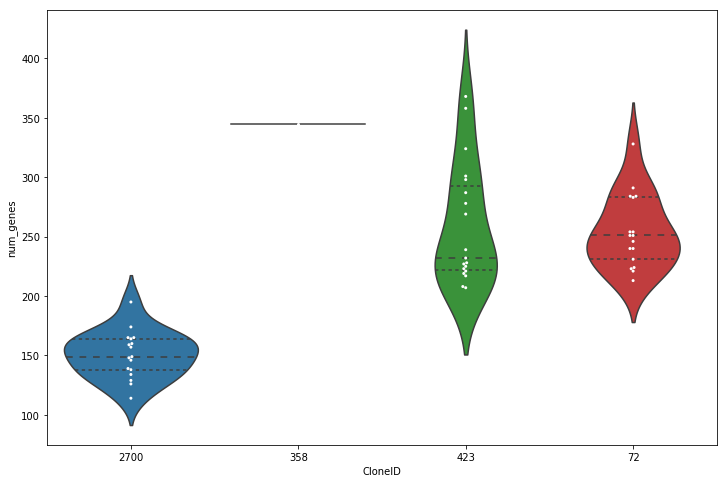

In [13]:
nG = nGene(EM_raw, meta_df)

Now we pick out the "good cells", whose expressed-gene-number is within 25% of the mean (within each clone).

In [14]:
nG_std = nG.groupby('CloneID').apply(np.std)
nG_means = nG.groupby('CloneID').apply(np.mean)
nG_lowcut = (nG_means*0.75).num_genes
nG_highcut = (nG_means*1.25).num_genes
cells_good = [c for c in cells if 
              (nG.num_genes[c] >= nG_lowcut[nG.CloneID[c]]) and 
              (nG.num_genes[c] <= nG_highcut[nG.CloneID[c]]) 
             ]
print('{} cells remaining after {} poor libraries removed.'.format(len(cells_good), len(cells) - len(cells_good)))

50 cells remaining after 4 poor libraries removed.


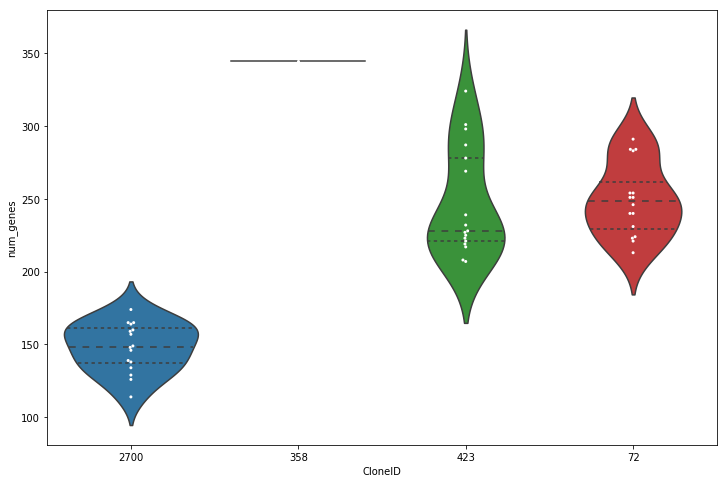

In [15]:
nG = nGene(EM_raw.loc[cells_good], meta_df.loc[cells_good]) # Post-trimming violin-plot.

Now we clip our data, declaring all expressions below zero (or a threshold) to be dropouts.

In [16]:
EM = EM_raw[genes_relevant].copy()  # Only use relevant genes.
EM = EM.loc[cells_good] # Only use good cells.
EM.clip_lower(0, inplace = True) # Clip any negative values to zero.
EM.dropna(inplace = True) # Get rid of all rows with NaNs too.

With our preprocessing complete, we pickle the data for later.

In [17]:
EM.to_pickle('10x65-67_EM.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix pickled, with shape {}'.format(EM.shape)) 

Expression matrix pickled, with shape (50, 708)


<a id='Desc'></a>
## 2.  Description and exploration

Start here if the data has already been preprocessed!

We explore the data a bit more closely, before tackling the serious questions. We begin by loading and reviewing the data from pickles.

In [18]:
EM = pd.read_pickle('10x65-67_EM.pkl') # Load expression matrix from a pickle.
meta_df = pd.read_pickle('10x65-67_meta.pkl') # Load metadata from a pickle.

genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.
meta_df = meta_df.loc[cells] # Only include relevant cells in meta_df hereafter.

clones = meta_df['CloneID'].unique()
areas = meta_df['Area'].unique()

print("{} Microglia cells are loaded, from {} to {}.".format(len(cells), cells[0], cells[-1]))
print("{} genes are loaded, from {} to {}.".format(len(genes),genes[0],genes[-1]))
print("The cells belong to {} clones: {}.".format(len(clones),', '.join(clones)))
print("The cells come from {} areas: {}.".format(len(areas),', '.join(areas)))

50 Microglia cells are loaded, from CGGCAGTGTCACCGAC_1 to TTTGTTGTCCGTGACG_3.
708 genes are loaded, from Nrgn to Ptprc.
The cells belong to 4 clones: 423, 72, 2700, 358.
The cells come from 3 areas: cx, hc, str.


### 2.1.  Cell demographics

We examine the metadata more closely, and tabulate the populations of the clones and within each area.  The areas are denoted cx (cortex), hc (hippocampus), and str (striatum).

In [19]:
pop_table = pd.DataFrame(index = list(clones)+['total'], columns = list(areas)+['total'] )
for clone in clones:
    for area in areas:
        ca_pop = len(meta_df[ (meta_df['CloneID'] == clone) & (meta_df['Area'] == area)])
        pop_table.loc[clone, area] = ca_pop

for clone in clones:
    pop_table.loc[clone, 'total'] = len(meta_df[ (meta_df['CloneID'] == clone)])

for area in areas:
    pop_table.loc['total', area] = len(meta_df[ (meta_df['Area'] == area)])

print('The following table gives the number of cells within each clone and area.')
display(pop_table)

The following table gives the number of cells within each clone and area.


,cx,hc,str,total
423,5,0,12,17
72,1,0,15,16
2700,0,16,0,16
358,0,1,0,1
total,6,17,27,NaN


The clones are mostly associated with a specific area.  Clone 72 is found almost exclusively in the striatum, while clone 2700 is found almost exclusively in the hippocampus.  Clone 423 is found about 2/3 in the striatum and 1/3 in the cortex.  Clone 358 is too small (1 cell) to be included.

This relationship between clonality and area means that we will have to be careful to disentangle whether gene expression depends on clonality or on area.  

In [22]:
clones = [clone for clone in clones if clone not in ['358']]
cells = [cell for cell in cells if meta_df.loc[cell, 'CloneID'] in clones]
print('{} cells belong to clones with >1 cell.'.format(len(cells)))

49 cells belong to clones with >1 cell.


### 2.2.  Gene examination and dropouts

We examine the gene expressions a bit more closely now.  We begin with a table of descriptive statistics for each gene.

In [23]:
EM.describe()

,Nrgn,Ube2c,C1qa,Snca,Trf,Tmem141,1110017D15Rik,Grb14,P2ry12,Ppp1r14a,...,Myl12a,Yjefn3,2610528A11Rik,Car12,Ubash3b,Hmgn2,Ptgfrn,Tle4,Cyr61,Ptprc
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.056215,0.044069,4.639816,0.071353,2.038051,0.317410,0.053869,0.114165,4.568430,0.106204,...,1.064652,0.004051,0.647078,0.200462,1.957551,0.160499,0.360297,0.335983,0.033701,3.368980
std,0.164894,0.311612,0.421394,0.246891,1.319201,0.731057,0.341372,0.401716,1.083218,0.525607,...,1.099287,0.019380,2.392195,1.414149,2.036054,0.352931,1.139991,0.738807,0.226106,3.490038
min,0.000000,0.000000,2.991749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,4.449792,0.000000,1.443118,0.000000,0.000000,0.000000,4.253527,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,4.703140,0.000000,2.293899,0.000000,0.000000,0.000000,4.746436,0.000000,...,1.145954,0.000000,0.000000,0.000000,1.965010,0.000000,0.000000,0.000000,0.000000,2.335758
75%,0.000000,0.000000,4.911648,0.000000,2.842604,0.056124,0.000000,0.000000,5.276293,0.000000,...,2.037177,0.000000,0.028974,0.000000,3.483249,0.033108,0.072407,0.000000,0.000000,6.623713
max,0.742375,2.203432,5.489158,1.059766,3.961226,2.916345,2.415484,1.769280,5.763818,2.685049,...,3.237319,0.110715,10.000000,10.000000,7.459430,1.360481,4.774626,2.729685,1.599368,10.000000


Now we examine the zeros (dropouts) and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above zero).  The *mean nonzero* is the mean of the expression of the gene, restricting to the nonzero expressions.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.

In [24]:
def dropmean(df):
    no_cells = len(df)
    max_expression = df.max()
    dropout_df = df.apply(lambda column: ((column > 0.0).sum()) / no_cells )
    meannz_df = df.apply(lambda column: column.replace(0, np.nan).mean()) # Use NaN to exclude from mean computation.
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

//anaconda/envs/Genomics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


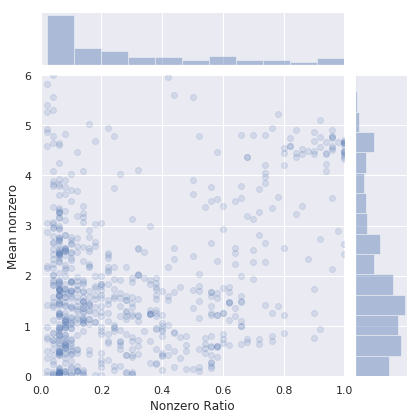

In [25]:
dm_df = dropmean(EM) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,6), height=6)

This distribution requires a bit more study.

<a id='SVM'></a>
## 3.  Machine learning via linear SVM

To what extent is gene expression correlated, or even predictive, of clonality?  Of the area in which a cell is found?  We take a supervised machine learning approach to these question, training the computer to predict clonality and area from gene expression.

First we load a large number of scikit-learn packages.

In [26]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
from statsmodels.formula.api import ols
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE # In case we want to cluster.

We set up our feature matrix `X` (gene expressions) and classes (clones) `y` below.

In [27]:
X = EM.loc[cells] # Include only the clones with >1 cell.
X_cells = X.index
y = meta_df.loc[X_cells].CloneID

### 3.2.  General-purpose functions

The following functions will be used to visualize the results of the machine learning algorithms.

In [28]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [29]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None, proportion = True):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    if proportion:
        valid = counts.apply(lambda column : column/cpops['pop'])
    else:
        valid = counts
    
    f, ax = plt.subplots(figsize=(8,7))
    if proportion:
        fmt = '2.0%'
    else:
        fmt = 'd'
    sns.heatmap(valid, annot=valid, square=True, fmt=fmt, linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    if proportion:
        cbar.set_ticks([0, .25, .5, .75, 1])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [56]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [57]:
def vis_genebars(ef, mf, genelist, prop, classlist = None,z_score=True, binarize=False, 
                 cutoff = 1.0, num_genes = False, sort=True, 
                 genelabels = True, fitlabels = False, celllabels = False):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        num_genes:  Plot an extra row, for the total number of genes expressed.
        sort:  If True, sort and hierarchically cluster the genes.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > 0.0).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    df[prop] = mf[prop]
    if classlist:
        df = sort_by(df, prop, classlist)
    else:
        df.sort_values(prop, inplace=True)
    
    cells = df.index
    md = mf.loc[cells]
    if classlist:
        classes = classlist
    else:
        classes = md[prop].unique()

    # Create plot.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    fig, axes = plt.subplots(2,1, sharex = True, figsize=(12, figheight), 
                             gridspec_kw = {'height_ratios':[0.25, 11.75], 'hspace':0.005})
    
    
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    evenpal = pal[1::2]
    pal[1::2] = evenpal[::-1] # Make palette zebra-striped to distinguish adjacent classes.
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)
    
    div_pal = sns.diverging_palette(220, 20, n=25)
    
    # Resort genes, based on hierarchical clustering and distance.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'
    if sort:
        Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
        genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]
    else:
        genelist_sort = genelist
        
    if num_genes:
        genelist_sort = ['num_genes'] + genelist_sort 
    
    if binarize:
        sns.heatmap(df[genelist_sort].transpose(), cmap='magma', ax=axes[1], cbar = None)
    elif zscore:
        sns.heatmap(df[genelist_sort].transpose(), vmin=-3, vmax=3, cmap = div_pal, ax=axes[1], 
                    cbar_kws={"orientation": "horizontal", "fraction":0.025, "pad":0.025})
    

    axes[0].vlines(cells,0,0.05, colors = colors, 
                   linewidth = 72*12 / len(cells), 
                   offsets = (72*6 / len(cells), 0))

    for c in classes:
        mdp = md[md[prop] == c]
        midcell = mdp.index[len(mdp) // 2]
        axes[0].text(midcell, 0.065, c, horizontalalignment='center')

    axes[0].axis('off')
    axes[0].grid(False)

    axes[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=celllabels) # labels along the bottom edge are off by default

    if genelabels:
        axes[1].tick_params(axis='y', rotation=0)
    else:
        axes[1].yaxis.set_ticklabels([])

    title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    if binarize:
        title.append('Binarized gene expression.')
    elif z_score:
        title.append('Color represents z-score.')
    fig.suptitle('\n '.join(title))
    plt.show()

### 3.3.  Linear SVM.

In [58]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=100)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=1000)) ])

param_grid = dict(skb__k = [2,5,10,50,100,150,200,250], svm__C = [0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=4, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=100, score_func=<function f_classif at 0x1c1ebaf8c8>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'skb__k': [2, 5, 10, 50, 100, 150, 200, 250], 'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

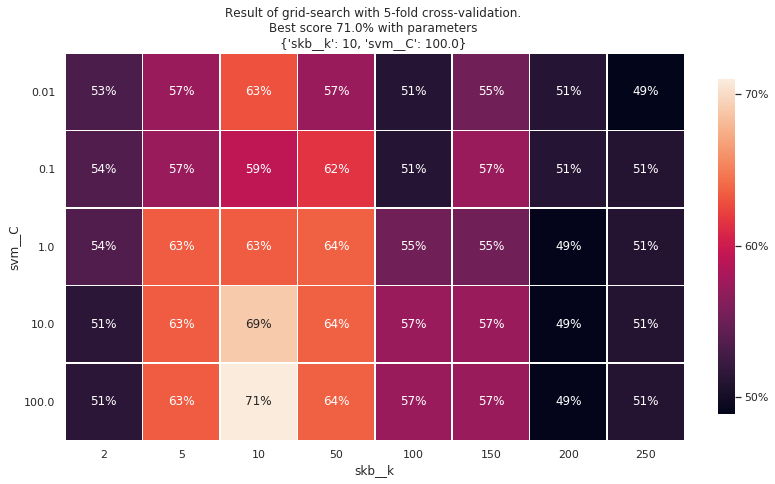

In [59]:
CV_map(grid_search, swap=True)

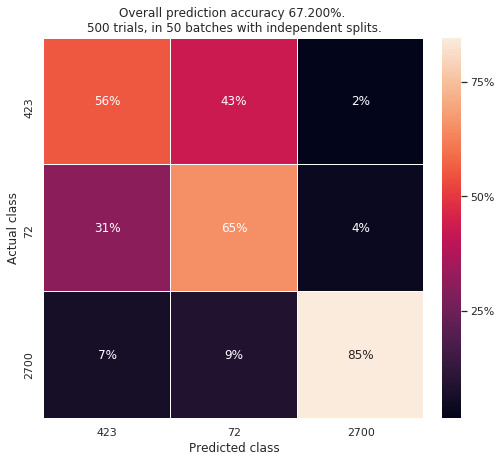

In [60]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

confusion_matrix(X,y,SVM_pipe, reps=50, classlist = clones)

The classifier distinguishes Clone 2700 from the others pretty accurately on the basis of 10 genes.  But Clones 423 and 72 are frequently confused with each other (though it's still better than chance!).  This may be related to the fact that Clones 423 and 72 both contain many cells from the striatum.  It would be interesting to refine the classification by area, to see if cortex-cells from Clone 423 are more easily distinguished from Clone 72.

In [61]:
pop_table.loc[clones] # See the imbalance below!

,cx,hc,str,total
423,5,0,12,17
72,1,0,15,16
2700,0,16,0,16


The support vector machine operates by first normalizing all gene expressions to be between 0 and 1.  Then it selects the top 10 genes by ANOVA F-statistic, for distinguishing clones.  Here we study the resulting 10 genes, when the SVM is run on the entire training set (all cells from small clones).

In [62]:
SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=10)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

The 10 differentially expressed genes (selected by ANOVA F) are: Fam216b, Pf4, Ppp1r32, Nostrin, Klf4, Car9, Ccr1, Itga4, Nlrc4, Thbd


To see how these genes distinguish clones, we visualize their expression levels below.  

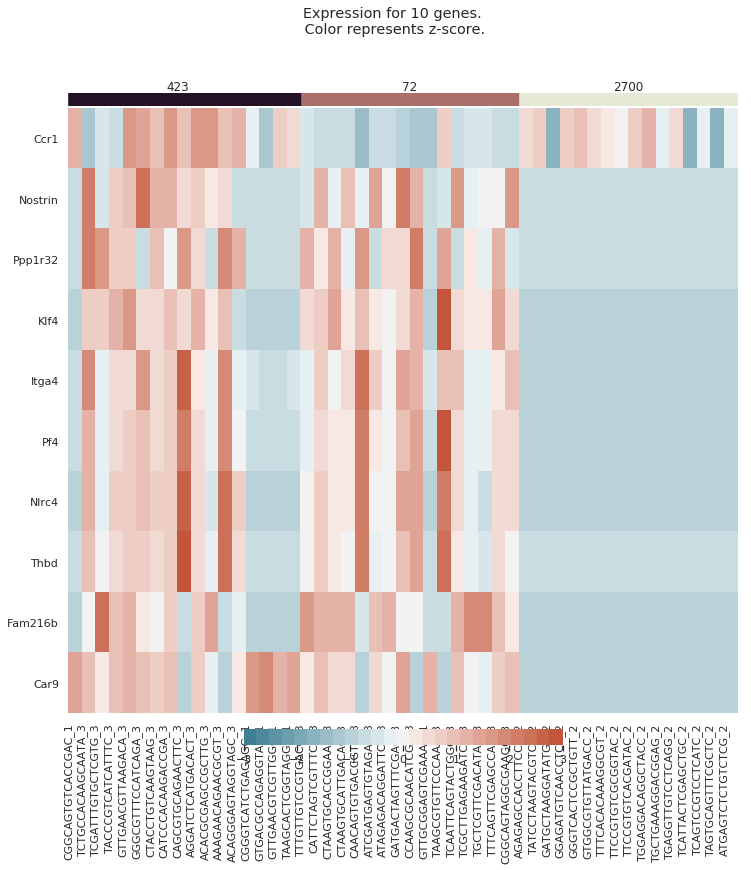

In [63]:
vis_genebars(X, meta_df, diff_genes, 'CloneID', classlist = clones, celllabels=True)

In [64]:
clone423 = meta_df[ meta_df.CloneID == '423']
display(clone423)

,CloneID,Celltype,Area,Clonesize
CGGCAGTGTCACCGAC_1,423,Microglia,cx,19.0
CGGGTCATCTGAGAGG_1,423,Microglia,cx,19.0
GTGACGCCAGAGGTAC_1,423,Microglia,cx,19.0
GTTGAACGTCGTTGGC_1,423,Microglia,cx,19.0
TAAGCACTCGGTAGGA_1,423,Microglia,cx,19.0
AAAGAACAGAACGCGT_3,423,Microglia,str,19.0
ACACGCGAGCCGCTTG_3,423,Microglia,str,19.0
ACAGGGAGTAGGTAGC_3,423,Microglia,str,19.0
AGGATCTCATGACACT_3,423,Microglia,str,19.0
CAGCGTGCAGAACTTC_3,423,Microglia,str,19.0


In [65]:
[cell for cell in cells if (meta_df.loc[cell].CloneID == '72') and (meta_df.loc[cell].Area == 'cx')]

['GTTGCGGAGTCGAAAT_1']

From looking at the cell labels and locations in the table and expression chart, the first (far-left) and last four (right) cells of Clone 423 are located in the cortex.  There is a clear difference in gene expression, when comparing these cortex-cells of Clone 423 to the other (striatum) cells -- look at the blue vertical stripe exhibiting low expression of Nostrin, Ppp1r32, Klf4, Itga4, Pf4, Nlrc4, Thbd, and Fam216b.  

The striatum cells of Clone 423 behave like the striatum cells of Clone 72.  In fact, the one cortex cell of Clone 72 behaves like the cortex cell of Clone 423 with respect to those seven genes.

Clone 2700 (the hippocampus cells) are distinguished from the others by those seven genes as well as Car9 being off.

While not perfect, the gene Ccr1 helps to distinguish clones 423 from 72, regardless of location.

If we look at more genes (40 genes, below), we see a stronger location-signal than clonality signal. 

The 50 differentially expressed genes (selected by ANOVA F) are: P2ry12, Hexb, Lyz2, Laptm5, Cx3cr1, Mrc1, Fam216b, Pf4, Dqx1, Mef2c, Evi2a, Selplg, Cenpe, Spp1, Tmem119, Reep5, Ppp1r32, Nostrin, Srgn, Cdh5, Sparc, Klf4, Sbf1, Ctsh, Car9, Timp2, Siglech, H2afx, Coro6, Basp1, Ccr1, Lyve1, Itga4, Nlrc4, Ms4a6c, Apoc1, Opn3, Adgb, Qk, Ttn, Itgam, Slfn5, Rnf13, Sgk2, Ifi203, Ankrd13a, Emb, Isg15, Syt6, Thbd


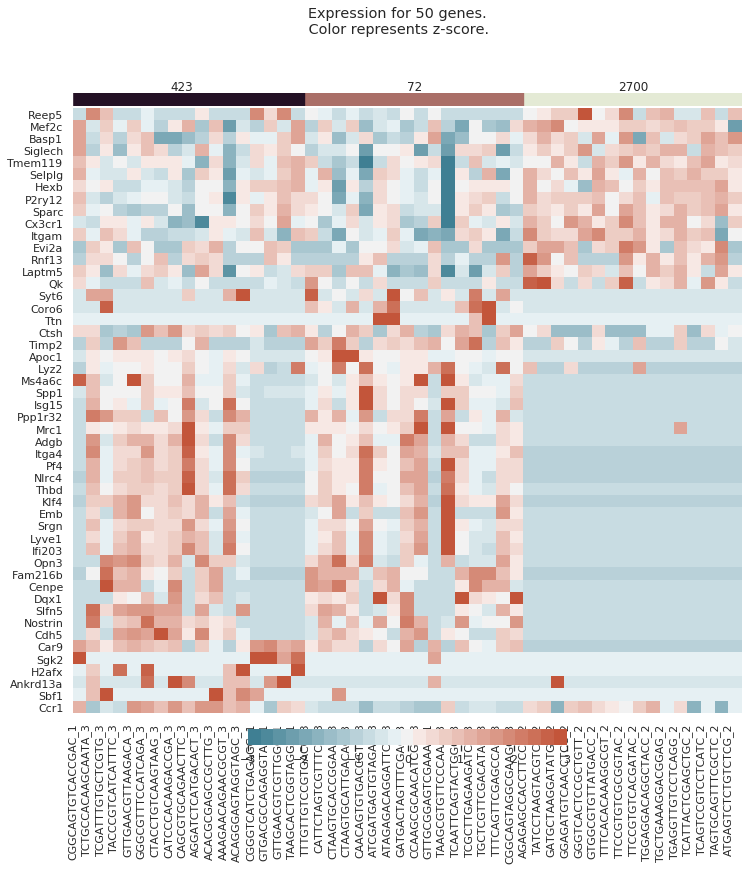

In [66]:
SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=opt_svm__C, max_iter=1000)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

vis_genebars(X, meta_df, diff_genes, 'CloneID', classlist = clones, celllabels=True)

So let's restrict to cells in the striatum (so only clones 72 and 423), and apply the same machine learning process.

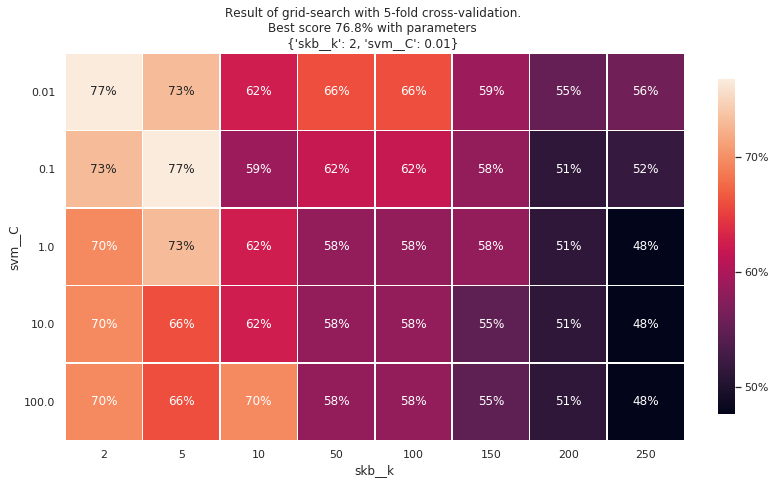

In [86]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=100)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=1000)) ])

param_grid = dict(skb__k = [2,5,10,50,100,150,200,250], svm__C = [0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=4, iid=False) #5-fold cross-validation.
grid_search.fit(X_str,y_str)
CV_map(grid_search, swap=True)

The highest accuracy occurs with just 2 (or 5) genes!  Let's see the confusion matrix.

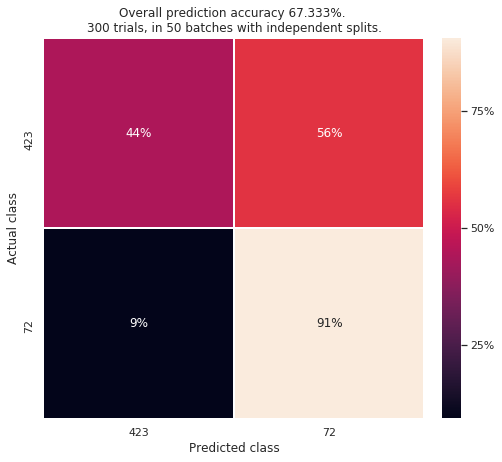

In [87]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=2)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.01, max_iter=1000)) ])

confusion_matrix(X_str,y_str,SVM_pipe, reps=50, classlist = ['423', '72'])

Now let's examine the 5 genes that distinguish clones 423 and 72, even after we restrict to striatum cells.

The 5 differentially expressed genes (selected by ANOVA F) are: H2afx, Ccr1, Ppp2r1a, Ccr5, Ankrd13a


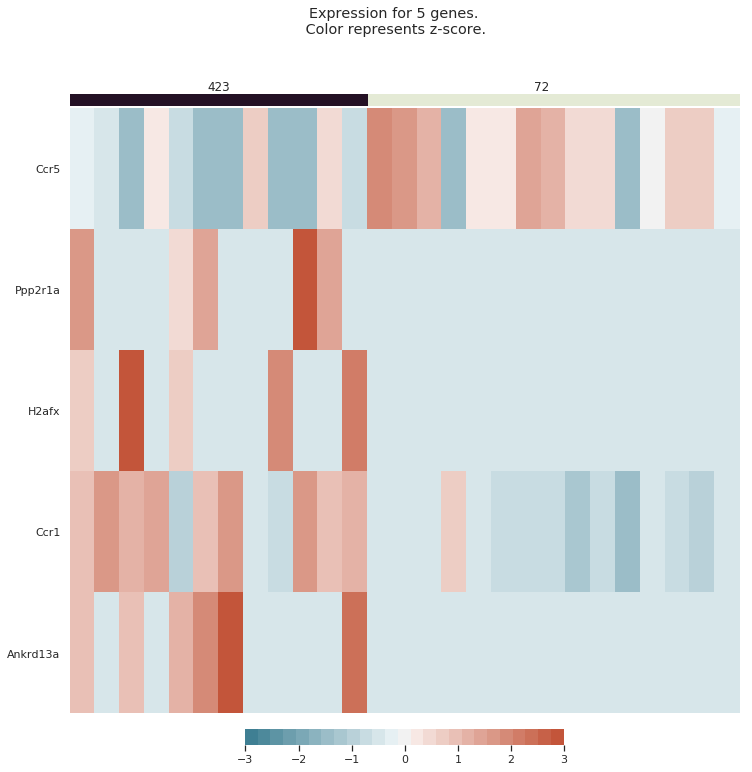

In [88]:
cells_str = [cell for cell in cells if meta_df.loc[cell].Area == 'str'] #Only striatum cells

X_str = X.loc[cells_str]
y_str = y.loc[cells_str]

SVM_pipe = Pipeline([('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=5)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=1000)) ])

SVM_pipe.fit(X_str,y_str)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes),', '.join(diff_genes)))

vis_genebars(X_str, meta_df, diff_genes, 'CloneID', classlist = ['423', '72'])

While no single gene provides a definitive signal at the single-cell level, there appear to be clonal differences.  By considering all five genes together, one gets a pretty good (about 75% accurate) indicator of clonality, even within cells of the striatum. 

<a id='DGE'></a>
## 4.  Differential gene expression